##### Detección de tópicos en ciencia básica: topicos con modelo entrenado

0. Filtrar documentos
1. Aplicar tf-idf
* Guardar



---
**To do** 
- detectar en inngles
- Documentos repetidos entre repositorios y convocatorias
- mismo proyecto 
-


In [13]:
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize

import heapq

nltk.download('wordnet')
nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package wordnet to /tmp/7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /tmp/7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df_texto_eval = pd.read_csv("./data_training_por_evaluador.csv")
df_texto_eval.rename(columns={"CVUCVU":"CVU"},inplace=True)
df_texto_eval.head()

,CVU,DESCRIPCION_PROYECTO_join,USUARIO,CVUCVU.1,NOMBRE,CVE_RCEA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,PALABRAS_CLAVE,APELLIDOS
0,26,antecedent nacional desarroll 20132018 estable...,X_jpena904,904.0,JUAN JOSE PE?A CABRIALES,RCEA-06-06773-2002,MATEMATICAS,NaN,CENTRO DE INVESTIGACION Y DE ESTUDIOS AVANZADO...,MEX,DF,"Inteligencia artificial, Agricultura urbana y ...",JUAN JOSE PE?A CABRIALES
1,37,antecedent biosensor conform general element r...,X_hmorales22194,22194.0,HELDA ELEONORA DE GUADALUPE MORALES,RCEA-06-11606-2006,MATEMATICAS,NaN,EL COLEGIO DE LA FRONTERA SUR,MEXICO,CHIAPAS,"Inteligencia artificial, Agricultura urbana y ...",HELDA ELEONORA DE GUADALUPE MORALES
2,42,antecedent global canc principal caus muert mu...,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,"Inteligencia artificial, Agricultura urbana y ...",ARTURO PEREZ VAZQUEZ
3,49,titul prepropuest apropiacion sociedad pobr ru...,X_gordonez11603,11603.0,GERARDO MANUEL ORDO?EZ BARBA,RCEA-05-06026-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",GERARDO MANUEL ORDO?EZ BARBA
4,67,impact cambi climat sobr surgenci coster pacif...,X_facosta12725,12725.0,FELIX ACOSTA DIAZ,RCEA-05-06058-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",FELIX ACOSTA DIAZ


In [23]:
texto = df_texto_eval["DESCRIPCION_PROYECTO_join"]

#### obtener tfidf
 regresa matriz documentos raices

## --- Hacer grid search (to do)

In [24]:
n_features = 512 #number of max words
n_top_words = 30 #words per topic

doc_similarity_thr = 0.15

In [25]:
max_df = .15
min_df = 5
tfidf_vectorizer = TfidfVectorizer(max_df= max_df, min_df=min_df,
                                   max_features=n_features)

In [26]:
import time

t0 = time.time()


tfidf = tfidf_vectorizer.fit_transform(texto)
t1 = time.time()
total = t1-t0
print(total)

18.929893493652344


## 2. Tópicos

Fit the NMF model (generalized Kullback-Leibler divergence)

In [27]:
n_components = round(sqrt(df_texto_eval["CVU"].nunique()))

n_components # borrar con nuevos docs

49

In [28]:
n_components = 50
n_components # borrar con nuevos docs

50

In [29]:
import time

t0 = time.time()

topic_model = NMF(n_components=round(n_components), random_state=123,
                  beta_loss='kullback-leibler', solver='mu', max_iter=200, alpha=.1,
                  l1_ratio=.5)

topic_model.fit(tfidf)

t1 = time.time()
total = t1-t0
print(total)

26.872331142425537


In [30]:
feature_names = tfidf_vectorizer.get_feature_names()

In [31]:
len(topic_model.components_[0])

512

In [32]:
topic_data = []

for topic_idx, topic in enumerate(topic_model.components_):
    index = [i for i in range(len(topic))]
    words = [feature_names[i] for i in index]
    value = [topic[i] for i in index]
    #print(value)
    topic_data.append({"index":index, "words":words, "value":value})
    #message = "Topic #%d: " % topic_idx
    #message += " ".join(words)
    #print(message)
#print()

In [33]:
filter_id = "AAA"

df_topicos_nombre = pd.DataFrame([t['words'] for t in topic_data])
df_topicos_nombre.index = [filter_id + str(t).zfill(3) for t in df_topicos_nombre.index]
df_topicos_nombre.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos_nombre.columns]
df_topicos_nombre.head(3)

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,...,W503,W504,W505,W506,W507,W508,W509,W510,W511,W512
AAA000,abandon,abej,abiot,abus,acarr,acer,acuacultur,acuat,acuicol,acuicultur,...,violenci,viral,virtual,virulent,volc,volcan,voltaj,wast,zacatec,zeolit
AAA001,abandon,abej,abiot,abus,acarr,acer,acuacultur,acuat,acuicol,acuicultur,...,violenci,viral,virtual,virulent,volc,volcan,voltaj,wast,zacatec,zeolit
AAA002,abandon,abej,abiot,abus,acarr,acer,acuacultur,acuat,acuicol,acuicultur,...,violenci,viral,virtual,virulent,volc,volcan,voltaj,wast,zacatec,zeolit


In [34]:
df_topicos = pd.DataFrame([t['value'] for t in topic_data])
df_topicos.index = [filter_id + str(t).zfill(3) for t in df_topicos.index]
df_topicos.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos.columns]
df_topicos.head(3)

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,...,W503,W504,W505,W506,W507,W508,W509,W510,W511,W512
AAA000,0.011133,0.02292,0.05012,0.0,0.071049,0.013974,0.025543,0.000549,0.039504,0.037407,...,0.0,0.000015,0.0,0.02776,0.001867,0.000003,0.000000,0.081961,0.004702,0.000198
AAA001,0.000000,0.00000,0.00000,0.0,0.000000,0.186845,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.00000,0.000000,0.001349,0.295957,0.000587,0.000000,0.004551
AAA002,0.000000,0.00000,0.00000,0.0,0.006412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.072336,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3. topicos por eval


generamos una lista de los varloes de los diccionarios:

In [41]:
lista_topicos = df_topicos.index.tolist()
dataframe_values = pd.DataFrame(columns=lista_topicos,index=[row for row in range(tfidf[:].shape[0])])

In [42]:
topics_results = []
numero_de_matches = 50
for i_doc in range(tfidf[:].shape[0]):


    valor_topico = np.array([tfidf[i_doc,topic["index"]].sum() for topic in topic_data]) #pesos de topicos
    dictionary = dict(zip(lista_topicos, valor_topico))
    
    dataframe_values.iloc[i_doc,:] = valor_topico
    #appendeamos en el DF:
    df_texto_eval.loc[i_doc,"topic_vector"] = str(dictionary)


In [43]:
df_texto_eval.head(10)

,CVU,DESCRIPCION_PROYECTO_join,USUARIO,CVUCVU.1,NOMBRE,CVE_RCEA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,PALABRAS_CLAVE,APELLIDOS,topic_vector
0,26,antecedent nacional desarroll 20132018 estable...,X_jpena904,904.0,JUAN JOSE PE?A CABRIALES,RCEA-06-06773-2002,MATEMATICAS,NaN,CENTRO DE INVESTIGACION Y DE ESTUDIOS AVANZADO...,MEX,DF,"Inteligencia artificial, Agricultura urbana y ...",JUAN JOSE PE?A CABRIALES,"{'AAA000': 3.6911055372940758, 'AAA001': 3.691..."
1,37,antecedent biosensor conform general element r...,X_hmorales22194,22194.0,HELDA ELEONORA DE GUADALUPE MORALES,RCEA-06-11606-2006,MATEMATICAS,NaN,EL COLEGIO DE LA FRONTERA SUR,MEXICO,CHIAPAS,"Inteligencia artificial, Agricultura urbana y ...",HELDA ELEONORA DE GUADALUPE MORALES,"{'AAA000': 2.6456705130435227, 'AAA001': 2.645..."
2,42,antecedent global canc principal caus muert mu...,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,"Inteligencia artificial, Agricultura urbana y ...",ARTURO PEREZ VAZQUEZ,"{'AAA000': 2.3421963516913125, 'AAA001': 2.342..."
3,49,titul prepropuest apropiacion sociedad pobr ru...,X_gordonez11603,11603.0,GERARDO MANUEL ORDO?EZ BARBA,RCEA-05-06026-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",GERARDO MANUEL ORDO?EZ BARBA,"{'AAA000': 3.7651163479301277, 'AAA001': 3.765..."
4,67,impact cambi climat sobr surgenci coster pacif...,X_facosta12725,12725.0,FELIX ACOSTA DIAZ,RCEA-05-06058-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",FELIX ACOSTA DIAZ,"{'AAA000': 2.4409951778940338, 'AAA001': 2.440..."
5,83,implementacion sistem hibr celd solaresccru si...,X_hgonzalez164212,206295.0,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",HUMBERTO GONZALEZ GALBAN,"{'AAA000': 4.146897963998512, 'AAA001': 4.1468..."
6,116,introduccion planteamient problem actual grand...,X_facosta12725,12725.0,FELIX ACOSTA DIAZ,RCEA-05-06058-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",FELIX ACOSTA DIAZ,"{'AAA000': 1.9921933021051008, 'AAA001': 1.992..."
7,144,analisis parametr electr generacion energi med...,X_jtorres10457,10457.0,JESUS GERARDO TORRES SALCIDO,RCEA-05-05987-2002,SOCIOLOGIA,NaN,UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,MEXICO,DISTRITO FEDERAL,"Pobreza, Seguridad alimentaria, Capacidades",JESUS GERARDO TORRES SALCIDO,"{'AAA000': 1.5357265344116553, 'AAA001': 1.535..."
8,156,resum propon desarroll sistem administracion m...,X_jarzate122299,122299.0,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE","Pobreza, Seguridad alimentaria, Capacidades",JORGE GUADALUPE ARZATE SALGADO,"{'AAA000': 1.5506921959997417, 'AAA001': 1.550..."
9,159,crecient preocupacion actual sobr medi ambient...,X_pmendoza9133,9133.0,PEDRO MENDOZA DE GIVES,RCEA-06-07171-2002,MEDICINA VETERINARIA,NaN,INSTITUTO NACIONAL DE INVESTIGACIONES FORESTAL...,MEX,EMEX,NaN,PEDRO MENDOZA DE GIVES,"{'AAA000': 2.9048850124561145, 'AAA001': 2.904..."


### TF_idf_vector

In [44]:
df_texto_eval["tfidf_vector"] = [dict(zip(tfidf_vectorizer.get_feature_names(),tfidf.toarray()[row])) for row in range(len(df_texto_eval))]

In [45]:
df_texto_eval.head()

,CVU,DESCRIPCION_PROYECTO_join,USUARIO,CVUCVU.1,NOMBRE,CVE_RCEA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,PALABRAS_CLAVE,APELLIDOS,topic_vector,tfidf_vector
0,26,antecedent nacional desarroll 20132018 estable...,X_jpena904,904.0,JUAN JOSE PE?A CABRIALES,RCEA-06-06773-2002,MATEMATICAS,NaN,CENTRO DE INVESTIGACION Y DE ESTUDIOS AVANZADO...,MEX,DF,"Inteligencia artificial, Agricultura urbana y ...",JUAN JOSE PE?A CABRIALES,"{'AAA000': 3.6911055372940758, 'AAA001': 3.691...","{'abandon': 0.0, 'abej': 0.0, 'abiot': 0.0, 'a..."
1,37,antecedent biosensor conform general element r...,X_hmorales22194,22194.0,HELDA ELEONORA DE GUADALUPE MORALES,RCEA-06-11606-2006,MATEMATICAS,NaN,EL COLEGIO DE LA FRONTERA SUR,MEXICO,CHIAPAS,"Inteligencia artificial, Agricultura urbana y ...",HELDA ELEONORA DE GUADALUPE MORALES,"{'AAA000': 2.6456705130435227, 'AAA001': 2.645...","{'abandon': 0.0, 'abej': 0.0, 'abiot': 0.0, 'a..."
2,42,antecedent global canc principal caus muert mu...,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,"Inteligencia artificial, Agricultura urbana y ...",ARTURO PEREZ VAZQUEZ,"{'AAA000': 2.3421963516913125, 'AAA001': 2.342...","{'abandon': 0.0, 'abej': 0.0, 'abiot': 0.0, 'a..."
3,49,titul prepropuest apropiacion sociedad pobr ru...,X_gordonez11603,11603.0,GERARDO MANUEL ORDO?EZ BARBA,RCEA-05-06026-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",GERARDO MANUEL ORDO?EZ BARBA,"{'AAA000': 3.7651163479301277, 'AAA001': 3.765...","{'abandon': 0.018942733422169566, 'abej': 0.0,..."
4,67,impact cambi climat sobr surgenci coster pacif...,X_facosta12725,12725.0,FELIX ACOSTA DIAZ,RCEA-05-06058-2003,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,"Pobreza extrema, Seguridad alimentaria, Perdid...",FELIX ACOSTA DIAZ,"{'AAA000': 2.4409951778940338, 'AAA001': 2.440...","{'abandon': 0.0, 'abej': 0.0, 'abiot': 0.0, 'a..."


In [46]:
data_json = df_texto_eval.head(50).to_json(orient='records')

In [ ]:
import json
with open('./data_records.json', 'w', encoding='utf-8') as f:
    json.dump(data_json, f, indent=4)

In [48]:
df_texto_eval.to_csv("./texto_dummies.csv",index=False)

# Pruebas

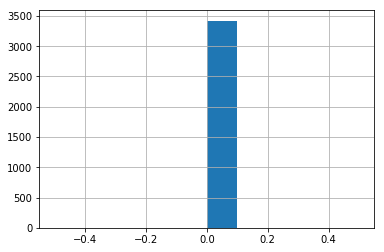

In [104]:
dataframe_values.sum(axis=1).hist()

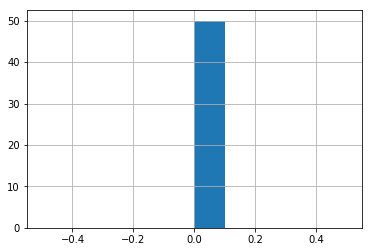

In [105]:
dataframe_values.sum(axis=0).hist()

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


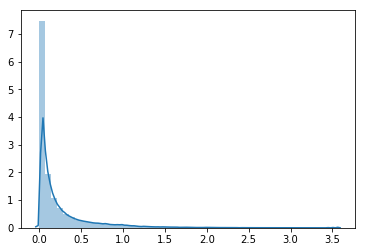

In [211]:
import seaborn as sns
sns.distplot(dataframe_values.values.flatten(1).tolist())

Se guardan en una lista el nombre de los topicos y su puntaje de mayor a menor para cada texto. 


In [44]:
df_texto_eval

,NOMBRE,RCEA,DESCRIPCION_PROYECTO_join,textos_por_eval,len_text,topicos_dictionary
0,HUGO SERGIO GARCIA GALINDO,RCEA-06-06751-2002,problem nacional pretend atend cultiv agricol ...,42,176299,"{'AAA000': 0.6769039859523549, 'AAA001': 0.279..."
1,RAMON MARCOS SOTO HERNANDEZ,RCEA-06-06763-2002,estim perd postcosech gran pais desarroll apro...,42,174266,"{'AAA000': 1.488872510531862, 'AAA001': 0.1128..."
2,JOSE GERARDO ROJAS PILONI,RCEA-02-10094-2005,present proyect propuest enmarc problemat naci...,34,143702,"{'AAA000': 0.057526052514180706, 'AAA001': 0.3..."
3,JOSE LUIS GARCIA HERNANDEZ,RCEA-06-10610-2005,problem nacional pretend atend produccion alim...,34,142975,"{'AAA000': 1.256105871159715, 'AAA001': 0.1595..."
4,GUADALUPE BEATRIZ XOCONOSTLE CAZARES,RCEA-06-07183-2002,conoc potencial bacteri analiz agent biocontro...,33,140708,"{'AAA000': 0.9552071422760078, 'AAA001': 0.112..."
5,ANDREA CUCINA,RCEA-04-12766-2006,antecedent acerc part posguerr observ movimien...,29,136622,"{'AAA000': 0.04670072239204813, 'AAA001': 0.08..."
6,VICTOR HUGO CRUZ ESCALONA,RCEA-02-13056-2006,prioritari ocean aprovech calamar recurs pesqu...,32,136560,"{'AAA000': 0.3195424121567129, 'AAA001': 0.589..."
7,ROSENBERG JAVIER ROMERO DOMINGUEZ,RCEA-07-08873-2003,resum present proyect dirig desarroll material...,33,132390,"{'AAA000': 0.19377440565846651, 'AAA001': 2.30..."
8,CESAR RAUL GONZALEZ BONILLA,RCEA-03-03483-2002,proyect investigacion somet convocatori proyec...,30,131309,"{'AAA000': 0.05909132079555049, 'AAA001': 0.03..."
9,FRANCISCO ALFONSO LARQUE SAAVEDRA,RCEA-06-06754-2002,lid investigacion boehring ingelheim vetmed ha...,32,126105,"{'AAA000': 1.4529889072312814, 'AAA001': 0.050..."


In [ ]:
df_texto_eval.to_csv("./evaluador_topicos.csv", index=False)